# What is Retrieval-Augmented Generation (RAG)?

**Retrieval-Augmented Generation (RAG)** is a process that enhances the output of a large language model (LLM) by retrieving relevant information from external knowledge sources before generating a response. While LLMs are trained on vast amounts of data, they can sometimes provide inaccurate or outdated information. RAG mitigates these issues by fetching authoritative and up-to-date information from external databases or document repositories, ensuring the generated output is more accurate and contextually relevant.


## Why is Retrieval-Augmented Generation Important?

LLMs are integral to artificial intelligence (AI) applications like chatbots and natural language processing (NLP) systems. However, LLMs face several challenges:

- **False Information**: When LLMs don’t have the answer, they might generate false information confidently.
- **Outdated Information**: LLMs are trained on static datasets, which may not reflect recent developments.
- **Non-Authoritative Sources**: Generated responses may not cite trusted sources.
- **Terminology Confusion**: LLMs may confuse terminology across different data sources.

These limitations can affect user trust. RAG addresses these challenges by enabling the LLM to retrieve relevant, trusted information from predefined sources, leading to more accurate and trustworthy responses.


## Benefits of Retrieval-Augmented Generation

1. **Cost-Effective Implementation**:
   - Instead of retraining expensive models, RAG allows you to augment existing LLMs by connecting them to domain-specific data sources.

2. **Access to Current Information**:
   - RAG allows LLMs to fetch the latest data from news sites, live social media feeds, or real-time APIs, ensuring the information is always up-to-date.

3. **Enhanced User Trust**:
   - Responses can be backed by source attribution, increasing transparency and confidence in the answers provided by the LLM.

4. **Increased Developer Control**:
   - Developers can manage the LLM’s information sources, update content, and fine-tune the system for different user contexts.

## How Does Retrieval-Augmented Generation Work?

1. **Create External Data**:
   - External data sources (e.g., APIs, databases, documents) are converted into embeddings (numerical representations) and stored in a **vector database**. This forms a knowledge library that the generative model can access.

2. **Retrieve Relevant Information**:
   - When a user submits a query, it is converted into a vector and matched with the most relevant documents in the vector database. This ensures the LLM receives accurate, contextually relevant information.

3. **Augment the LLM Prompt**:
   - The retrieved information is added to the original query as context, forming an augmented prompt. This helps the LLM generate more accurate and relevant responses.

4. **Update External Data**:
   - To keep the information current, external data sources and their embeddings are updated asynchronously through batch processing or real-time updates.

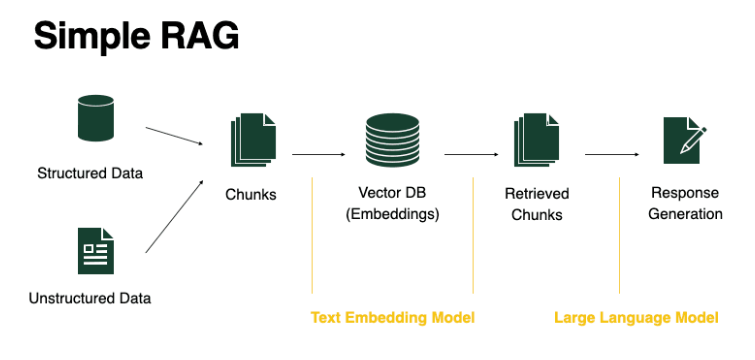

## Building a RAG Model

To implement this RAG-based system, we will follow these steps:

### Step 1: Data Preparation
- Load the dataset or documents containing the information that the QA bot will use to answer questions.
- Convert this data into embeddings using a model like **Cohere API** (or a similar generative model) to create numerical representations that can be stored in a vector database.

### Step 2: Storing Embeddings in Vector Database
- Set up a vector database to store and retrieve document embeddings efficiently.

### Step 3: Query Processing and Information Retrieval
- When a user asks a question, convert the query into an embedding and use Pinecone to retrieve the most relevant document sections by comparing vector similarities.

### Step 4: Answer Generation
- Pass the retrieved document sections to the LLM (e.g., Cohere) along with the query. The LLM will use this context to generate a coherent and relevant answer.

### Step 5: Frontend Interface
- Develop a frontend using **Streamlit** or **Gradio** to allow users to upload documents, ask questions, and receive answers in real-time.

### Step 6: Testing and Refinement
- Test the model with multiple queries and documents to ensure it provides accurate and contextually relevant responses. Fine-tune the system based on performance and feedback.

### Step 7: Deployment and Containerization
- Dockerize the application for easy deployment and scalability, ensuring that it can handle large datasets and multiple queries efficiently.

## Install Necessary Libraries


In [1]:
%%capture

%pip install llama-index-llms-groq
%pip install llama-index-retrievers-bm25
%pip install llama-index-embeddings-nvidia
%pip install llama-index-embeddings-huggingface

!pip install llama-index

## Import Libraries

This code imports key libraries for building a Retrieval-Augmented Generation (RAG) model:

- **Pandas** (`import pandas as pd`): For data manipulation and analysis.
- **IPython Utilities**: 
  - `io`: Captures output in Jupyter notebooks.
  - `Markdown, display`: Renders Markdown and rich outputs.
- **Typing**: (`from typing import ...`): Provides type hints for clarity.
- **Llama Index Components**:
  - **Groq**: Accesses the Groq language model for text generation.
  - **BM25Retriever**: Implements the BM25 algorithm for keyword-based retrieval.
  - **NVIDIAEmbedding**: Uses NVIDIA models for text embeddings.
  - **SentenceSplitter**: Splits documents into sentences.
  - **RetrieverEvaluator**: Evaluates retriever performance.
  - **RetrieverQueryEngine**: Processes queries and interacts with the retriever.
  - **HuggingFaceEmbedding**: Integrates Hugging Face models for embeddings.
  - **BaseRetriever, VectorIndexRetriever**: Base and vector-based retrieval classes.
  - **Settings, VectorStoreIndex, SimpleDirectoryReader**: Configuration and document handling.

These libraries work together to create and evaluate a robust RAG model.


In [2]:
import pandas as pd

from IPython.utils import io
from IPython.display import Markdown, display
from typing import Any, Callable, Dict, List, Optional, cast

from llama_index.llms.groq import Groq
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.embeddings.nvidia import NVIDIAEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.retrievers import BaseRetriever, VectorIndexRetriever
from llama_index.core.schema import BaseNode, IndexNode, NodeWithScore, QueryBundle
from llama_index.core.evaluation import generate_question_context_pairs, EmbeddingQAFinetuneDataset
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader, get_response_synthesizer

## Step 1: Initializing the Embedding Model and Language Model

In this first step, we are setting up the foundation of our **Retrieval-Augmented Generation (RAG)** pipeline. This involves two critical components: the **embedding model** and the **language model (LLM)**. Both are essential to ensure that the system can understand and generate human-like text based on the user's queries.

### Why Start with Embedding and LLM Setup?

Before we can process any queries or context, we need to ensure that our system has the ability to:
1. **Convert text into vectors** (embeddings) that the system can efficiently search through.
2. **Generate responses** using a large language model based on the retrieved information.

Without setting up these two models first, the rest of the pipeline (retrieving relevant documents and generating responses) won't function properly. This is why we start with configuring these models.

---

### Step 1.1: Setting Up the Embedding Model

The embedding model is responsible for converting text (both queries and context) into vector representations. This allows us to perform similarity searches later, which is a core part of the RAG process.

`Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")`

- **Why this model?** The `"BAAI/bge-small-en-v1.5"` model is a compact and efficient embedding model. It's designed to handle English text, making it perfect for tasks where we need quick and accurate vector conversions, without sacrificing too much computational power.
  
This step is essential because the embedding model is how we will search through our data to find the most relevant context for each query.

---

### Step 1.2: Configuring the Language Model (LLM)

After setting up the embedding model, we configure the **language model**, which will be responsible for generating human-like responses. In our case, we are using **Groq’s LLaMA 3** model with 8 billion parameters.

`Settings.llm = Groq(model="llama3-8b-8192", api_key="your_api_key_here")`

- **Why LLaMA 3?** This model is both powerful and efficient, with 8 billion parameters, allowing it to handle complex, large-scale text generation tasks. It’s designed for tasks that require understanding context over long sequences, which is ideal for RAG pipelines.
- **API Key**: You’ll need to replace `your_api_key_here` with your actual Groq API key. This is required to authenticate and access the model’s services. You can obtain it from [Groq's API Portal](https://groq.com).

---

### Step 1.3: Quick Test of the Language Model

Before moving forward, it’s a good idea to quickly test that the language model is working as expected.

`print(Settings.llm.complete("Name 3 breeds of cats"))`

- **Why test now?** By running this quick test, we ensure that the language model is correctly set up and can generate responses. This helps catch any issues early on, rather than discovering them later in the workflow.
  
This step ensures that both the **embedding model** and **language model** are ready to handle text processing tasks, allowing you to confidently move on to the next phase of the RAG process.

---

By starting with these configurations, we are building the backbone of the RAG system, ensuring that it can accurately retrieve and generate responses for the queries we’ll process in later steps.


In [3]:
"""
Task Overview:
1. Initialize the embedding model for text-to-vector conversion.
2. Set up the language model (LLM) using Groq’s LLaMA 3.
3. Run a quick test to ensure the LLM is functioning correctly.
"""

# Step 1: Set up the embedding model
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# Step 2: Set up the language model (LLM)
Settings.llm = Groq(model="llama3-8b-8192", api_key="YOUR_GROQ_API_KEY")

# Step 3: Quick test to verify the LLM setup
print(Settings.llm.complete("Name 3 breeds of cats"))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Here are three breeds of cats:

1. Siamese
2. Persian
3. Maine Coon


## Step 2: Splitting Documents into Manageable Chunks

Now that we have set up the embedding and language model, the next step in our RAG pipeline is to **prepare the documents**. We need to split the documents into smaller, manageable chunks. This is important because language models perform better when dealing with smaller pieces of text rather than lengthy documents.

### Why Split the Documents?

Splitting the documents allows the system to retrieve and process more relevant sections of text based on the query. By breaking down the document into chunks, we can ensure that the model focuses on the most relevant portions, rather than processing the entire document at once.

---

### Step 2.1: Initialize the Text Splitter

We use the `SentenceSplitter` to break the documents into chunks of 1024 tokens. This is a crucial part of document preparation because it helps the model manage large documents more effectively.

`text_splitter = SentenceSplitter(chunk_size=1024)`

- **Why a chunk size of 1024?** We choose 1024 tokens as the chunk size because it strikes a good balance between providing enough context to the language model and avoiding overwhelming it with too much data. This chunk size is ideal for many models, as it provides enough context for meaningful analysis.

---

### Step 2.2: Loading the Documents

Next, we load the documents from a directory using the `SimpleDirectoryReader`. This function helps in reading all files from the specified directory and converting them into a format that the language model can work with.

`documents = SimpleDirectoryReader("/kaggle/input/anixa-bio-quarterly-10q").load_data()`

- **Why use `SimpleDirectoryReader`?** This reader allows us to efficiently load all documents from a specified directory and convert them into a list that can be easily processed in the next steps. It simplifies the process of ingesting text data from multiple files.

---

### Step 2.3: Splitting the Documents into Nodes

Once the documents are loaded, we split them into **nodes** using the `get_nodes_from_documents` method from the `SentenceSplitter`. Each node will be a chunk of the document, and this is what the model will process during the retrieval phase.

`nodes = text_splitter.get_nodes_from_documents(documents)`

- **Why use nodes?** Nodes represent the individual chunks of the document, each containing up to 1024 tokens. Splitting the document into nodes ensures that the language model can efficiently handle and retrieve smaller, relevant pieces of text based on the query.

---

### Step 2.4: Checking the Number of Nodes

Finally, we check the number of nodes created by the splitter to ensure the document has been successfully divided into manageable pieces.

`len(nodes)`

- **Why check the length?** This step allows us to verify that the document has been correctly split into chunks. The number of nodes gives us an idea of how many parts the document has been divided into, ensuring that the system will process smaller, manageable sections.

---

By splitting the documents into smaller chunks (or nodes), we are preparing them for retrieval, ensuring that the language model can focus on the most relevant parts when answering queries. This step is essential for improving the efficiency and accuracy of the RAG system.


In [4]:
"""
Task Overview:
1. Initialize the text splitter to break documents into chunks.
2. Load documents using SimpleDirectoryReader.
3. Split documents into nodes for efficient processing.
4. Check the number of nodes created.

Split documents into manageable parts for effective retrieval and processing by the language model.
"""

# Step 1: Initialize the text splitter
text_splitter = SentenceSplitter(chunk_size=1024)

# Step 2: Load the documents from the specified directory
documents = SimpleDirectoryReader("/kaggle/input/jessup-cellars").load_data()

# Step 3: Split documents into nodes (chunks)
nodes = text_splitter.get_nodes_from_documents(documents)

# Step 4: Check the number of nodes
len(nodes)

21

## Step 3: Creating the Vector Index for Document Retrieval

After splitting the documents into manageable nodes, the next step is to create a **vector index**. The vector index is essential for enabling fast and accurate document retrieval based on the user's query.

### Why Build a Vector Index?

In order to retrieve the most relevant chunks (or nodes) from our documents, we need a way to quickly search through them. The vector index allows us to store the document nodes as **vectors** in a high-dimensional space. When a query is made, the model will search for the nodes that are most similar to the query vector.

---

### Step 3.1: Initializing the Vector Index

We initialize the `VectorStoreIndex` by passing in the list of nodes that we generated in the previous step. This stores the nodes in a format that allows for similarity-based searches.

`vector_index = VectorStoreIndex(nodes)`

- **Why use `VectorStoreIndex`?** The `VectorStoreIndex` allows us to create an index that maps document chunks to vectors. This enables the retrieval of the most relevant chunks based on a query. The system will later compare the query vector to the node vectors in the index and return the most similar nodes.

---

### What Happens Next?

The vector index stores each chunk of the document as a vector. During the retrieval phase, we will use this index to perform a **similarity search**—matching the query to the most relevant document chunks. This is a crucial step in the Retrieval-Augmented Generation (RAG) model, allowing us to focus on the most relevant parts of the document when generating answers.


In [5]:
"""
Task Overview:
1. Create a vector index for document retrieval.
2. Store document nodes as vectors for fast similarity searches.
"""

# Step 1: Initialize the vector index with document nodes
vector_index = VectorStoreIndex(nodes)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Step 4: Building a Hybrid Retriever for Document Search

In this step, we create a **HybridRetriever** that combines both **semantic search** and **traditional BM25 search**. This allows us to leverage the strengths of both methods, improving the accuracy and relevance of our search results.

### Why Use a Hybrid Retriever?

By combining:
- **BM25 Retriever**: A keyword-based method focusing on term frequency.
- **Vector Retriever**: Uses semantic embeddings to capture meaning.

This hybrid approach enhances retrieval by capturing documents that might be overlooked by either method alone.

---

### Step 4.1: Custom Hybrid Retriever Class

We define the `HybridRetriever` class to integrate both retrieval mechanisms. Here's a brief overview:

```python
class HybridRetriever(BaseRetriever):
    def __init__(self, vector_retriever: VectorIndexRetriever, bm25_retriever: BM25Retriever) -> None:
        self.bm25_retriever = bm25_retriever
        self._vector_retriever = vector_retriever
        super().__init__()
```
        
- **Constructor**: Initializes both the BM25 and vector retrievers.
- **_retrieve Method**: Executes both retrievals and combines their results, ensuring comprehensive coverage.

### Key Components

- **bm25_nodes**: Nodes retrieved using the BM25 method.
- **vector_nodes**: Nodes retrieved based on semantic similarity.
- **combined_dict**: Merges results, eliminating duplicates.

`combined_dict = {n.node.node_id: n for n in bm25_nodes}`
`combined_dict.update({n.node.node_id: n for n in vector_nodes})`

---

### Why This Matters?

Using a hybrid method ensures a comprehensive set of relevant nodes by merging keyword-based and semantic search techniques, which is essential for diverse datasets where one method alone might fall short.


In [6]:
"""
Task Overview:
1. Create a hybrid retriever that combines semantic search and BM25 search.
2. Leverage both methods to enhance the accuracy and relevance of search results.
"""

# Step 4: Building a Hybrid Retriever for Document Search
class HybridRetriever(BaseRetriever):
    """Custom retriever that performs both semantic search and hybrid search."""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        bm25_retriever: BM25Retriever,
    ) -> None:
        """Initialize parameters for the hybrid retriever."""
        
        # Initialize the BM25 retriever for keyword-based searches
        self.bm25_retriever = bm25_retriever
        
        # Initialize the vector retriever for semantic searches
        self._vector_retriever = vector_retriever
        
        # Call the superclass constructor to ensure proper initialization
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given a query bundle."""

        # Step 4.1: Retrieve nodes using BM25
        bm25_nodes = self.bm25_retriever.retrieve(query_bundle)
        
        # Step 4.2: Retrieve nodes using vector search
        vector_nodes = self._vector_retriever.retrieve(query_bundle)

        # Step 4.3: Extract node IDs from BM25 results
        bm25_ids = {n.node.node_id for n in bm25_nodes}
        
        # Step 4.4: Extract node IDs from vector results
        vector_ids = {n.node.node_id for n in vector_nodes}

        # Step 4.5: Create a dictionary to combine results
        combined_dict = {n.node.node_id: n for n in bm25_nodes}
        
        # Step 4.6: Update the dictionary with vector results, avoiding duplicates
        combined_dict.update({n.node.node_id: n for n in vector_nodes})

        # Step 4.7: Return a list of unique nodes
        return list(combined_dict.values())

## Step 5: Initializing the Retrievers

In this step, we will initialize the semantic and BM25 retrievers and then create our **HybridRetriever**. This setup is essential for enabling our retrieval system to efficiently fetch relevant documents based on user queries.

### Setting Up the Retrievers

1. **Semantic Retriever**:
   We initialize the semantic retriever using the `VectorStoreIndex`. This retriever will fetch the top similar documents based on vector embeddings.

   ```python 
    semantic_retriever = vector_index.as_retriever(similarity_top_k=5)
    ```
   - **`similarity_top_k=5`**: This parameter specifies that we want to retrieve the top 5 most similar documents based on semantic similarity.

2. **BM25 Retriever**:
   Next, we create the BM25 retriever, which will use traditional keyword matching.
   ```python
   bm25_retriever = BM25Retriever(nodes=nodes, similarity_top_k=5)
    ```

   - **`nodes=nodes`**: This parameter feeds the nodes that we previously created from our documents.
   - **`similarity_top_k=5`**: Again, this retrieves the top 5 documents based on keyword relevance.

3. **Hybrid Retriever**:
   Finally, we instantiate our hybrid retriever that combines both methods.

   ```python
    retriever = HybridRetriever(semantic_retriever, bm25_retriever)
    ```

   - This combines both retrieval methods, allowing for a more robust search capability by leveraging the strengths of both semantic and keyword-based searching.

By setting up both retrievers, we ensure that our system can efficiently and effectively find relevant documents based on a variety of query types, improving overall accuracy and user satisfaction.


In [7]:
"""
Task Overview:
1. Initialize semantic and BM25 retrievers for document retrieval.
2. Create a hybrid retriever that combines both methods.
"""

# Step 5: Initializing the Retrievers

# Step 5.1: Set Up the Semantic Retriever
semantic_retriever = vector_index.as_retriever(similarity_top_k=5)

# Step 5.2: Set Up the BM25 Retriever
bm25_retriever     = BM25Retriever(nodes=nodes, similarity_top_k=5)

# Step 5.3: Create the Hybrid Retriever
retriever = HybridRetriever(semantic_retriever, bm25_retriever)


## Step 6: Generating Question-Context Pairs

In this step, we will create a dataset of question-context pairs using our language model (LLM). This is crucial for training and evaluating our retrieval-augmented generation (RAG) model.

### Creating Question-Context Pairs

We use the `generate_question_context_pairs` function to generate a set of questions based on the documents (nodes) we have.

```python
qa_dataset = generate_question_context_pairs(nodes, llm=Settings.llm, num_questions_per_chunk=1)
```

- **`nodes`**: This parameter includes the documents that will provide the context for the generated questions.
- **`llm=Settings.llm`**: We pass our language model, which will be responsible for generating the questions based on the context provided in the nodes.
- **`num_questions_per_chunk=1`**: This specifies that we want to generate one question for each chunk of context.

Generating question-context pairs is essential for evaluating how well our RAG model performs. By having a structured dataset of questions linked to specific contexts, we can assess the model's ability to provide accurate and relevant answers based on the retrieved information.


In [8]:
"""
Task Overview:
1. Generate question-context pairs for the RAG model.
2. Use a language model to create structured datasets for evaluation.

"""

# Step 6: Generating Question-Context Pairs

# Step 6.1: Create the Question-Context Dataset
qa_dataset = generate_question_context_pairs(
    nodes, llm=Settings.llm, num_questions_per_chunk=1
)


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


## Step 7: Evaluating the Retriever's Performance

In this step, we will evaluate the performance of our hybrid retriever using various metrics. This is a crucial part of ensuring that our model retrieves relevant information effectively.

### Defining Evaluation Metrics

We start by defining the metrics we want to use for evaluation:

`metrics = ["hit_rate", "mrr", "precision", "recall", "ap", "ndcg"]`

- **`hit_rate`**: Measures how often the correct answer appears in the top retrieved results.
- **`mrr`**: Mean Reciprocal Rank, indicating the average rank of the first relevant answer.
- **`precision`**: The ratio of relevant documents retrieved to the total documents retrieved.
- **`recall`**: The ratio of relevant documents retrieved to the total relevant documents available.
- **`ap`**: Average Precision, which averages precision scores at each relevant document.
- **`ndcg`**: Normalized Discounted Cumulative Gain, evaluating the ranking quality of the retrieved results.

### Initializing the Retriever Evaluator

We create an instance of the `RetrieverEvaluator` with the specified metrics:

`retriever_evaluator = RetrieverEvaluator.from_metric_names(metrics, retriever=retriever)`

### Evaluating the Dataset

Next, we evaluate the dataset using the defined metrics:

```python
with io.capture_output(): 
    eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)
```

- **`io.capture_output()`**: This context manager captures any output generated during the evaluation, keeping the console clean.
- **`await retriever_evaluator.aevaluate_dataset(qa_dataset)`**: This asynchronous method evaluates the retriever using the `qa_dataset`, returning the evaluation results.

Evaluating the retriever's performance with multiple metrics allows us to gain insights into its effectiveness and areas for improvement. By understanding how well the retriever performs, we can make informed decisions about further tuning or adjustments needed in our model.



In [9]:
"""
Task Overview:
1. Evaluate the performance of the hybrid retriever using various metrics.
2. Gain insights into the effectiveness of the retrieval system.
"""

# Step 7: Evaluating the Retriever's Performance

# Step 7.1: Define Evaluation Metrics
metrics = ["hit_rate", "mrr", "precision", "recall", "ap", "ndcg"]

# Step 7.2: Initialize the Retriever Evaluator
retriever_evaluator = RetrieverEvaluator.from_metric_names(metrics, retriever=retriever)

# Step 7.3: Evaluate the Dataset
with io.capture_output():
    eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)


## Step 8: Displaying Evaluation Results

In this step, we will define a function to display the results from the evaluation of our hybrid retriever. This will help us visualize the performance metrics we calculated in the previous step.

### Function to Display Results

We start by defining the `display_results` function, which takes in a name for the evaluation and the results to be displayed:

```python
def display_results(name, eval_results):
    """Display results from evaluate."""
    return pd.DataFrame({
        "desc": [name],
        **{k: [pd.DataFrame([eval_result.metric_vals_dict for eval_result in eval_results])[k].mean()] for k in metrics}
    })
```

- **Parameters**:
  - `name`: A string to identify the evaluation (e.g., "retrieval eval").
  - `eval_results`: The results obtained from the evaluation process.

- **Functionality**:
  - The function creates a DataFrame to organize the evaluation metrics in a structured format.
  - It computes the mean value for each metric across the evaluation results.

### Displaying the Results

Finally, we call the function with the evaluation results:

`display_results("retrieval eval", eval_results)`

Displaying the evaluation results in a structured format allows for easy interpretation and comparison of the performance metrics. This step is crucial for understanding how well our retriever is performing and identifying areas that may need improvement.


In [10]:
"""
Task Overview:
1. Define a function to display evaluation results.
2. Visualize the performance metrics calculated from the evaluation.
"""

# Step 8: Displaying Evaluation Results

# Step 8.1: Function to Display Results
def display_results(name, eval_results):
    """Display results from evaluate."""
    return pd.DataFrame({
        "desc": [name],
        **{k: [pd.DataFrame([eval_result.metric_vals_dict for eval_result in eval_results])[k].mean()] for k in metrics}
    })

# Step 8.2: Call the Function to Display Results
display_results("retrieval eval", eval_results)


,desc,hit_rate,mrr,precision,recall,ap,ndcg
0,retrieval eval,0.380952,0.122808,0.039683,0.380952,0.122808,0.041016


## Step 9: Setting Up the Query Engine

In this step, we will create a `RetrieverQueryEngine` that utilizes our hybrid retriever to process queries and synthesize responses. This engine will allow us to efficiently retrieve information and generate answers based on user queries.

### Creating the Query Engine

We initialize the query engine as follows:

```python
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=get_response_synthesizer(),
)
```

- **Parameters**:
  - `retriever`: This is our previously defined `HybridRetriever`, which combines semantic and BM25 retrieval methods.
  - `response_synthesizer`: This is set to the output of the `get_response_synthesizer()` function, which prepares the response mechanism.

### Why Use a Query Engine?

The `RetrieverQueryEngine` serves as the central component for handling user queries:
- It allows seamless interaction between the user and the retrieval system.
- It leverages the combined strengths of both the semantic and keyword-based retrieval methods to provide accurate and relevant responses.

By setting up this engine, we are ready to start processing queries and generating informative responses based on the retrieved data.


In [11]:
"""
Task Overview:
1. Create a query engine to process user queries.
2. Utilize the hybrid retriever to retrieve and synthesize responses.
"""

# Step 9: Setting Up the Query Engine

# Step 9.1: Create the Query Engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=get_response_synthesizer(),
)


## Step 10: Querying the Engine for Information

In this step, we will utilize our `RetrieverQueryEngine` to process a specific user query and obtain a response. This allows us to interact with our hybrid retrieval system and generate relevant answers based on the available data.

### Executing the Query

We execute a query as follows:

```python
response = query_engine.query(
    "YOUR_QUESTION"
)
```

- **Parameters**:
  - The string `"YOUR QUESTION"` is the user-defined question that we want to ask the system.

### Outputting the Response

After querying the engine, we print the result:

`print(str(response))`

- This converts the response to a string format and displays it in the output.

By querying the engine, we can retrieve specific information based on user input. This interaction showcases the effectiveness of the hybrid retrieval system in providing accurate and contextual answers based on the documents we have processed.


In [15]:
"""
Task Overview:
1. Query the retrieval engine for specific information.
2. Output the response from the engine.
"""

# Step 10: Querying the Engine for Information

# Step 10.1: Execute the Query
response = query_engine.query(
    "Are Dogs Allowed at Jessup Cellars?"
)

# Step 10.2: Output the Response
print(str(response))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Yes, Jessup Cellars is dog-friendly, allowing well-behaved canines inside or outside the premises.


In [13]:
# [response.source_nodes[1].text]  To see the first chnk used to generate the answer
len([node.text for node in response.source_nodes]) #No. of Chunks accessed to answer

7